### 可视化模型 `llava-v1.6-mistral-7b-hf` 在数据集 `tom-gibbs/multi-turn_jailbreak_attack_datasets` 上的隐藏层中的张量

#### 读取隐藏层张量及对应的labels, mt_nums

In [1]:
import torch

layer_0 = torch.load("./embeddings/pure_mt/layer_0.pt").to(torch.float32).cpu()
layer_8 = torch.load("./embeddings/pure_mt/layer_8.pt").to(torch.float32).cpu()
layer_16 = torch.load("./embeddings/pure_mt/layer_16.pt").to(torch.float32).cpu()
layer_24 = torch.load("./embeddings/pure_mt/layer_24.pt").to(torch.float32).cpu()
layer_32 = torch.load("./embeddings/pure_mt/layer_32.pt").to(torch.float32).cpu()

mt_nums = torch.load("./embeddings/pure_mt/mt_nums.pt").cpu() # 原始多轮对话轮数
labels = torch.load("./embeddings/pure_mt/labels.pt").cpu()   # 流式攻击标签，1为攻击成功， 0为攻击失败

#### 提取每个多轮对话的indices。如果该多轮对话安全，返回对应indices区间的最后一个indice。如果该多轮对话非安全，返回对应indices区间中第一个攻击成功的indice

In [2]:
selected_indices = []
mt_attack_labels = []   # 对应的多轮攻击标签，1为攻击成功， 0为攻击失败
attack_success_turns = []   # 对应的多轮攻击若成功，记录攻击成功所在的轮数；对应的多轮攻击若失败，以-1表示

start = 0
for interval_length in mt_nums.tolist():
    end = start + interval_length
    sub_labels = labels[start:end]
    # 查找第一个label==1的位置
    positive_indices = (sub_labels == 1).nonzero(as_tuple=True)[0]
    if len(positive_indices) > 0:
        # 如果存在1，取第一个1的索引（转换回labels的全局索引）
        selected_idx = start + positive_indices[0].item()
        mt_attack_labels.append(1)
        attack_success_turns.append(positive_indices[0].item() + 1) # 轮数从1开始计数
    else:
        # 否则取该段最后一个索引（多轮攻击失败sample）
        selected_idx = end - 1
        mt_attack_labels.append(0)
        attack_success_turns.append(-1)

    selected_indices.append(selected_idx)
    start = end

# 转为tensor
selected_indices = torch.tensor(selected_indices, dtype=torch.long)
mt_attack_labels = torch.tensor(mt_attack_labels, dtype=torch.long)
attack_success_turns = torch.tensor(attack_success_turns, dtype=torch.long)

In [10]:
# 假设 mt_attack_labels 和 mt_nums 都是一维张量
idx = (mt_attack_labels == 1).nonzero(as_tuple=True)[0]   # 攻击成功的索引
# 计算每个 idx[i] 位置的 “前 x 个数值的总和”
result = torch.tensor([mt_nums[:i+1].sum() for i in idx])
selected_indices[mt_attack_labels==1], result, idx

(tensor([ 47,  69,  81, 100, 117, 186, 195, 253, 378, 407, 492, 541, 567, 574,
         659]),
 tensor([ 48,  70,  82, 101, 118, 187, 196, 254, 379, 408, 493, 542, 568, 575,
         664]),
 tensor([ 3,  5,  6,  8, 10, 17, 18, 23, 35, 38, 46, 50, 52, 53, 61]))

#### 根据 `selected_indices` 选取对应的隐藏层的张量

In [4]:
layer_0_features = layer_0[selected_indices]
layer_8_features = layer_8[selected_indices]
layer_16_features = layer_16[selected_indices]
layer_24_features = layer_24[selected_indices]
layer_32_features = layer_32[selected_indices]

# def l2_normalize(tensor: torch.Tensor) -> torch.Tensor:
#     # 计算每个向量的 L2 范数，并避免除以 0
#     return tensor / (tensor.norm(p=2, dim=1, keepdim=True) + 1e-8)

# layer_0_features  = l2_normalize(layer_0_features)
# layer_8_features  = l2_normalize(layer_8_features)
# layer_16_features = l2_normalize(layer_16_features)
# layer_24_features = l2_normalize(layer_24_features)
# layer_32_features = l2_normalize(layer_32_features)

#### 三维及二维欧几里得空间 | tsne降维

/home/lsy/anaconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/lsy/anaconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/lsy/anaconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/lsy/anaconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/lsy/anaconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  

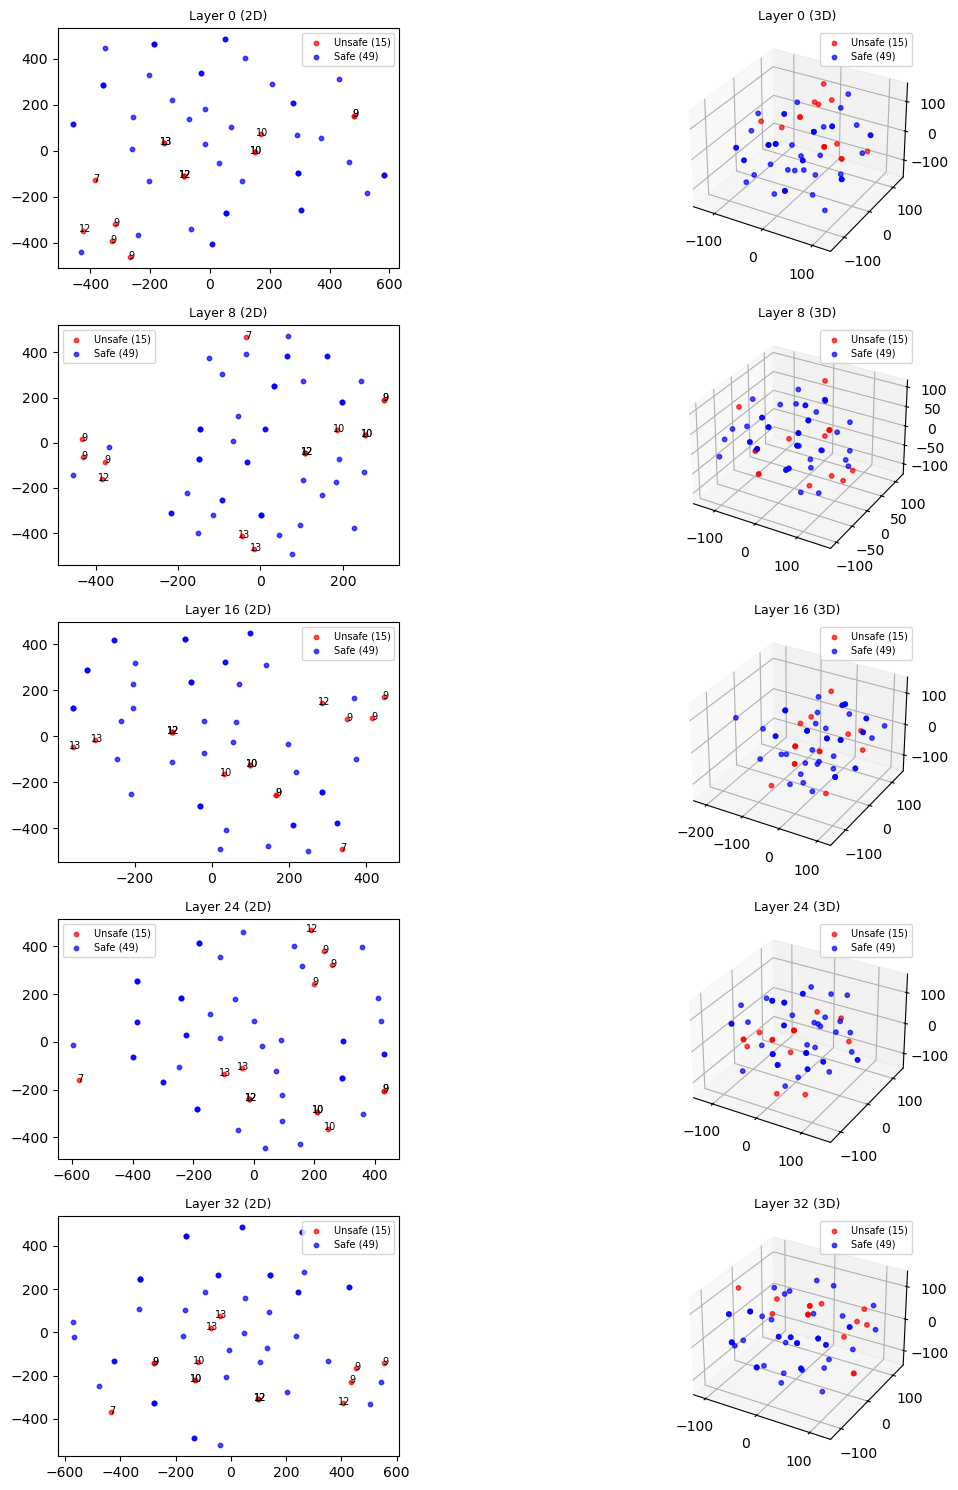

In [5]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import matplotlib.gridspec as gridspec

layers = {
    "Layer 0": layer_0_features,
    "Layer 8": layer_8_features,
    "Layer 16": layer_16_features,
    "Layer 24": layer_24_features,
    "Layer 32": layer_32_features
}

def get_perplexity(n_samples):
    return min(30, max(5, (n_samples - 1) // 3))

# 缩小整体画布
fig = plt.figure(figsize=(12, 15))        # 进一步缩小

# 控制左右子图宽度比例
gs = gridspec.GridSpec(len(layers), 3, width_ratios=[1, 1.1, 1.1])

for row, (layer_name, layer_tensor) in enumerate(layers.items()):
    X = layer_tensor.cpu().to(torch.float32).numpy()
    perplexity = get_perplexity(X.shape[0])

    unsafe_count = int((mt_attack_labels == 1).sum().item())
    safe_count = int((mt_attack_labels == 0).sum().item())

    tsne_2d = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=1000)
    X_2d = tsne_2d.fit_transform(X)

    tsne_3d = TSNE(n_components=3, random_state=42, perplexity=perplexity, n_iter=1000)
    X_3d = tsne_3d.fit_transform(X)

    # 2D 子图
    ax2d = fig.add_subplot(gs[row, 0])
    ax2d.scatter(X_2d[mt_attack_labels == 1, 0], X_2d[mt_attack_labels == 1, 1],
                c="red", label=f"Unsafe ({unsafe_count})", alpha=0.7, s=10)
    ax2d.scatter(X_2d[mt_attack_labels == 0, 0], X_2d[mt_attack_labels == 0, 1],
                c="blue", label=f"Safe ({safe_count})", alpha=0.7, s=10)

    # ⭐ 给攻击成功的点加文字标签
    for idx in torch.nonzero(mt_attack_labels == 1, as_tuple=True)[0]:
        turn_num = int(attack_success_turns[idx])        # 第几轮攻击成功
        x, y = X_2d[idx, 0], X_2d[idx, 1]
        ax2d.text(x + 5, y + 5, str(turn_num), fontsize=7, color="black",
                ha="center", va="center")

    ax2d.set_title(f"{layer_name} (2D)", fontsize=9)
    ax2d.legend(fontsize=7)

    # 3D 子图
    ax3d = fig.add_subplot(gs[row, 1:], projection="3d")
    ax3d.scatter(X_3d[mt_attack_labels == 1, 0], X_3d[mt_attack_labels == 1, 1], X_3d[mt_attack_labels == 1, 2],
                 c="red", alpha=0.7, s=10, label=f"Unsafe ({unsafe_count})")
    ax3d.scatter(X_3d[mt_attack_labels == 0, 0], X_3d[mt_attack_labels == 0, 1], X_3d[mt_attack_labels == 0, 2],
                 c="blue", alpha=0.7, s=10, label=f"Safe ({safe_count})")
    ax3d.set_title(f"{layer_name} (3D)", fontsize=9)
    ax3d.legend(fontsize=7)
    ax3d.set_box_aspect([1, 1, 0.7])      # 保持紧凑

# 减小子图间距
plt.subplots_adjust(wspace=0.05, hspace=0.25)
plt.tight_layout()
plt.show()

##### 投影至二维再映射到$R^{2,3}$双曲空间中

/home/lsy/anaconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/lsy/anaconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/lsy/anaconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/lsy/anaconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/lsy/anaconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  

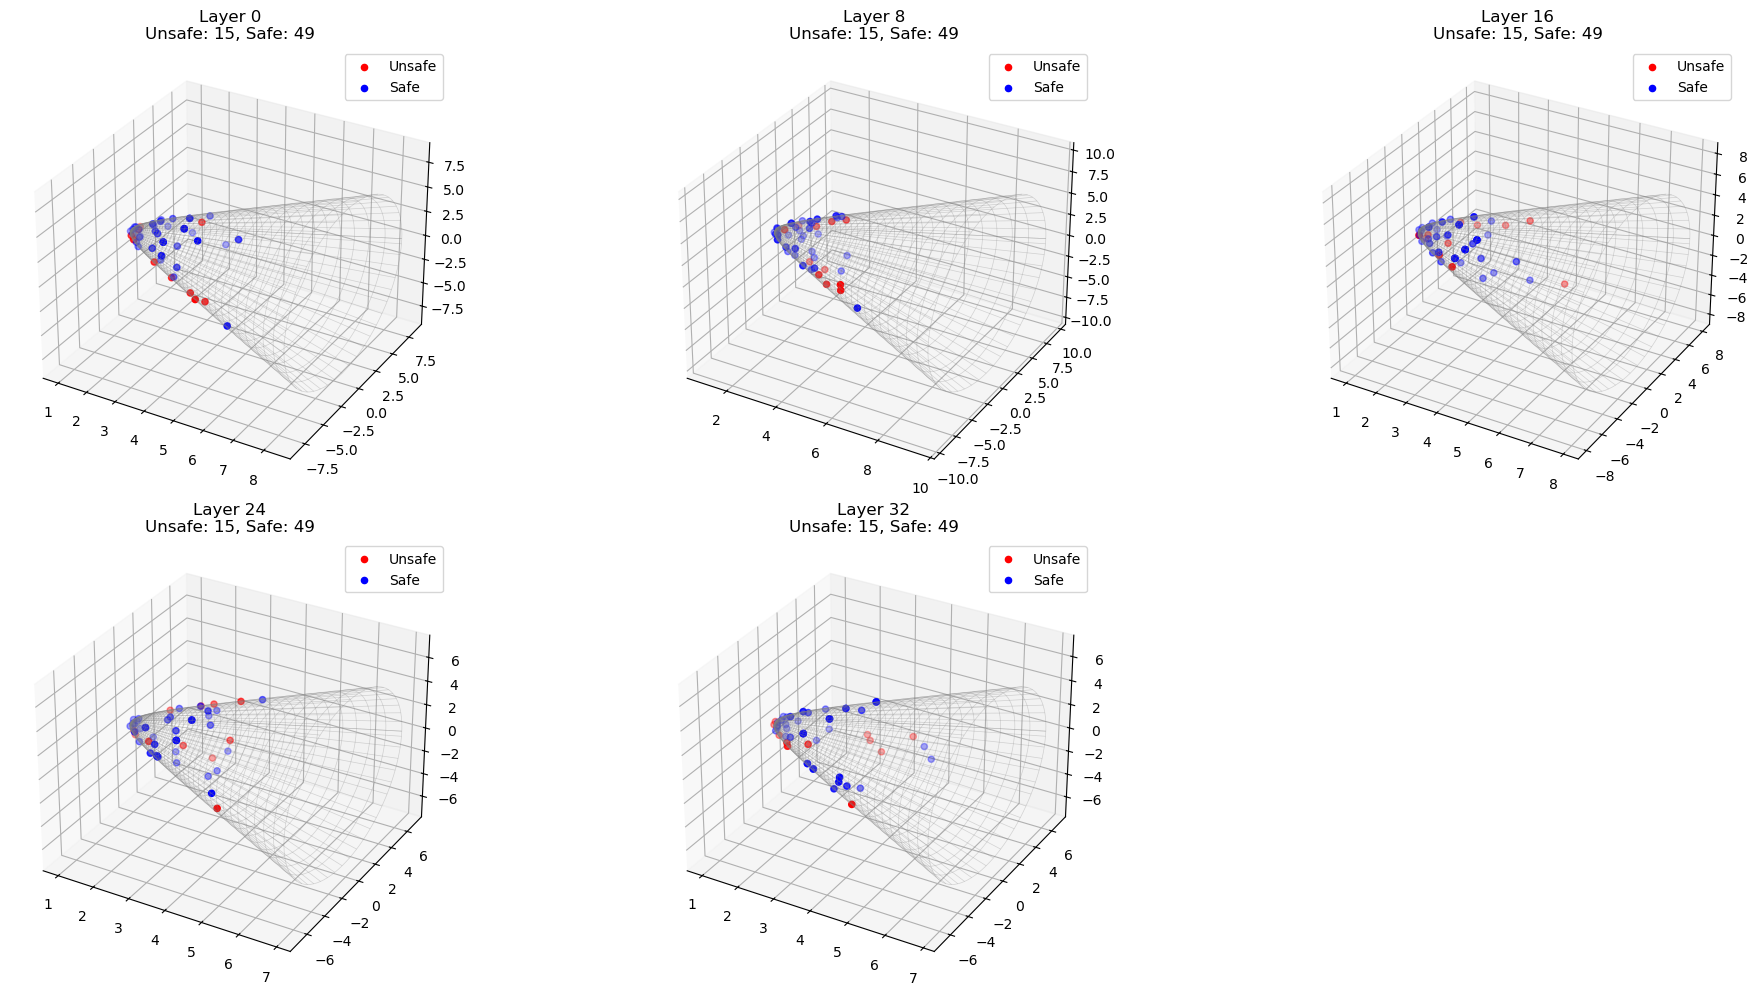

In [6]:
import sys, os
sys.path.append(os.path.abspath(os.path.join("..", "..")))
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from utils.lorentz import exp_map0

# exp map from R^2 -> H^2 ⊂ R^3
def exp_map_hyperboloid(x: torch.Tensor, curv: float = 1.0, eps: float = 1e-8) -> torch.Tensor:
    x_space = exp_map0(x, curv=curv, eps=eps)  # [B, D]
    x_time = torch.sqrt(1.0 / curv + torch.sum(x_space**2, dim=-1, keepdim=True))  # [B,1]
    return torch.cat([x_time, x_space], dim=-1)  # [B, D+1]


# 绘制双曲面网格，增加 curv 参数
def plot_hyperboloid_mesh(ax, r_max, curv: float = 1.0, n_r=50, n_theta=100, wireframe=True):
    r = np.linspace(0, r_max, n_r)
    theta = np.linspace(0, 2*np.pi, n_theta)
    R, Theta = np.meshgrid(r, theta)

    # 这里的公式保持与 exp_map_hyperboloid 一致
    X0 = np.sqrt(1.0 / curv + np.sinh(np.sqrt(curv) * R)**2)
    X1 = np.sinh(np.sqrt(curv) * R) * np.cos(Theta) / np.sqrt(curv)
    X2 = np.sinh(np.sqrt(curv) * R) * np.sin(Theta) / np.sqrt(curv)

    if wireframe:
        ax.plot_wireframe(X0, X1, X2, color="gray", alpha=0.3, linewidth=0.5)
    else:
        ax.plot_surface(X0, X1, X2, alpha=0.05, color="gray", linewidth=0, antialiased=False)


# 五个层的数据
layers = {
    "Layer 0": layer_0_features,
    "Layer 8": layer_8_features,
    "Layer 16": layer_16_features,
    "Layer 24": layer_24_features,
    "Layer 32": layer_32_features
}

def get_perplexity(n_samples):
    return min(30, max(5, n_samples // 3))

fig = plt.figure(figsize=(20, 10))
curv = 1.0  # 可以灵活调节曲率

for i, (layer_name, layer_tensor) in enumerate(layers.items(), 1):
    n_samples = layer_tensor.shape[0]
    perp = get_perplexity(n_samples)

    # ---------- t-SNE 降到 2D ----------
    tsne = TSNE(n_components=2, random_state=42, perplexity=perp, n_iter=1000)
    layer_embedded = tsne.fit_transform(layer_tensor.cpu().numpy())

    # ---------- z-score 标准化 ----------
    mean = layer_embedded.mean(axis=0, keepdims=True)
    std = layer_embedded.std(axis=0, keepdims=True) + 1e-8
    layer_embedded = (layer_embedded - mean) / std

    layer_embedded_torch = torch.tensor(layer_embedded, dtype=torch.float32)

    # ---------- exp map 到双曲面 (B,3) ----------
    hyperbolic_coords = exp_map_hyperboloid(layer_embedded_torch, curv=curv)

    # 动态确定曲面范围
    r_max = np.max(np.linalg.norm(layer_embedded, axis=1)) * 1.2

    ax = fig.add_subplot(2, 3, i, projection="3d")

    # 画大双曲面网格（传入 curv 参数）
    plot_hyperboloid_mesh(ax, r_max=r_max, curv=curv, wireframe=True)

    # 攻击成功 (红色圆点)
    ax.scatter(
        hyperbolic_coords[mt_attack_labels==1, 0],
        hyperbolic_coords[mt_attack_labels==1, 1],
        hyperbolic_coords[mt_attack_labels==1, 2],
        c="red", marker="o", label="Unsafe"
    )

    # 攻击失败 (蓝色圆点)
    ax.scatter(
        hyperbolic_coords[mt_attack_labels==0, 0],
        hyperbolic_coords[mt_attack_labels==0, 1],
        hyperbolic_coords[mt_attack_labels==0, 2],
        c="blue", marker="o", label="Safe"
    )

    # 标题里加数量统计
    n_success = (mt_attack_labels==1).sum().item()
    n_fail = (mt_attack_labels==0).sum().item()
    ax.set_title(f"{layer_name}\nUnsafe: {n_success}, Safe: {n_fail}")
    ax.legend()

plt.tight_layout()
plt.show()


#### $R^{4096,4097}$双曲空间上与原点$[\sqrt{\frac{1}{c}},0,...,0]$的洛伦兹距离分布，`curv=1.0`

In [ ]:
from utils.lorentz import exp_map0, elementwise_dist

# 定义双曲空间的曲率
curv = 1.0

# 逐层映射到双曲空间（只传空间维度）
layer_0_hyp  = exp_map0(layer_0_features,  curv=curv)
layer_8_hyp  = exp_map0(layer_8_features,  curv=curv)
layer_16_hyp = exp_map0(layer_16_features, curv=curv)
layer_24_hyp = exp_map0(layer_24_features, curv=curv)
layer_32_hyp = exp_map0(layer_32_features, curv=curv)

B, D = layer_0_hyp.shape  # D = 4096

# 构造原点 O（全零空间向量）
O = torch.zeros(D, device=layer_0_hyp.device, dtype=layer_0_hyp.dtype)
O = O.unsqueeze(0).expand(B, -1)  # [B, D]

# 分别计算每层到原点的距离
dist_0  = elementwise_dist(layer_0_hyp,  O, curv=curv)  # [B]
dist_8  = elementwise_dist(layer_8_hyp,  O, curv=curv)
dist_16 = elementwise_dist(layer_16_hyp, O, curv=curv)
dist_24 = elementwise_dist(layer_24_hyp, O, curv=curv)
dist_32 = elementwise_dist(layer_32_hyp, O, curv=curv)

/tmp/ipykernel_559224/484092529.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_kde.legend()


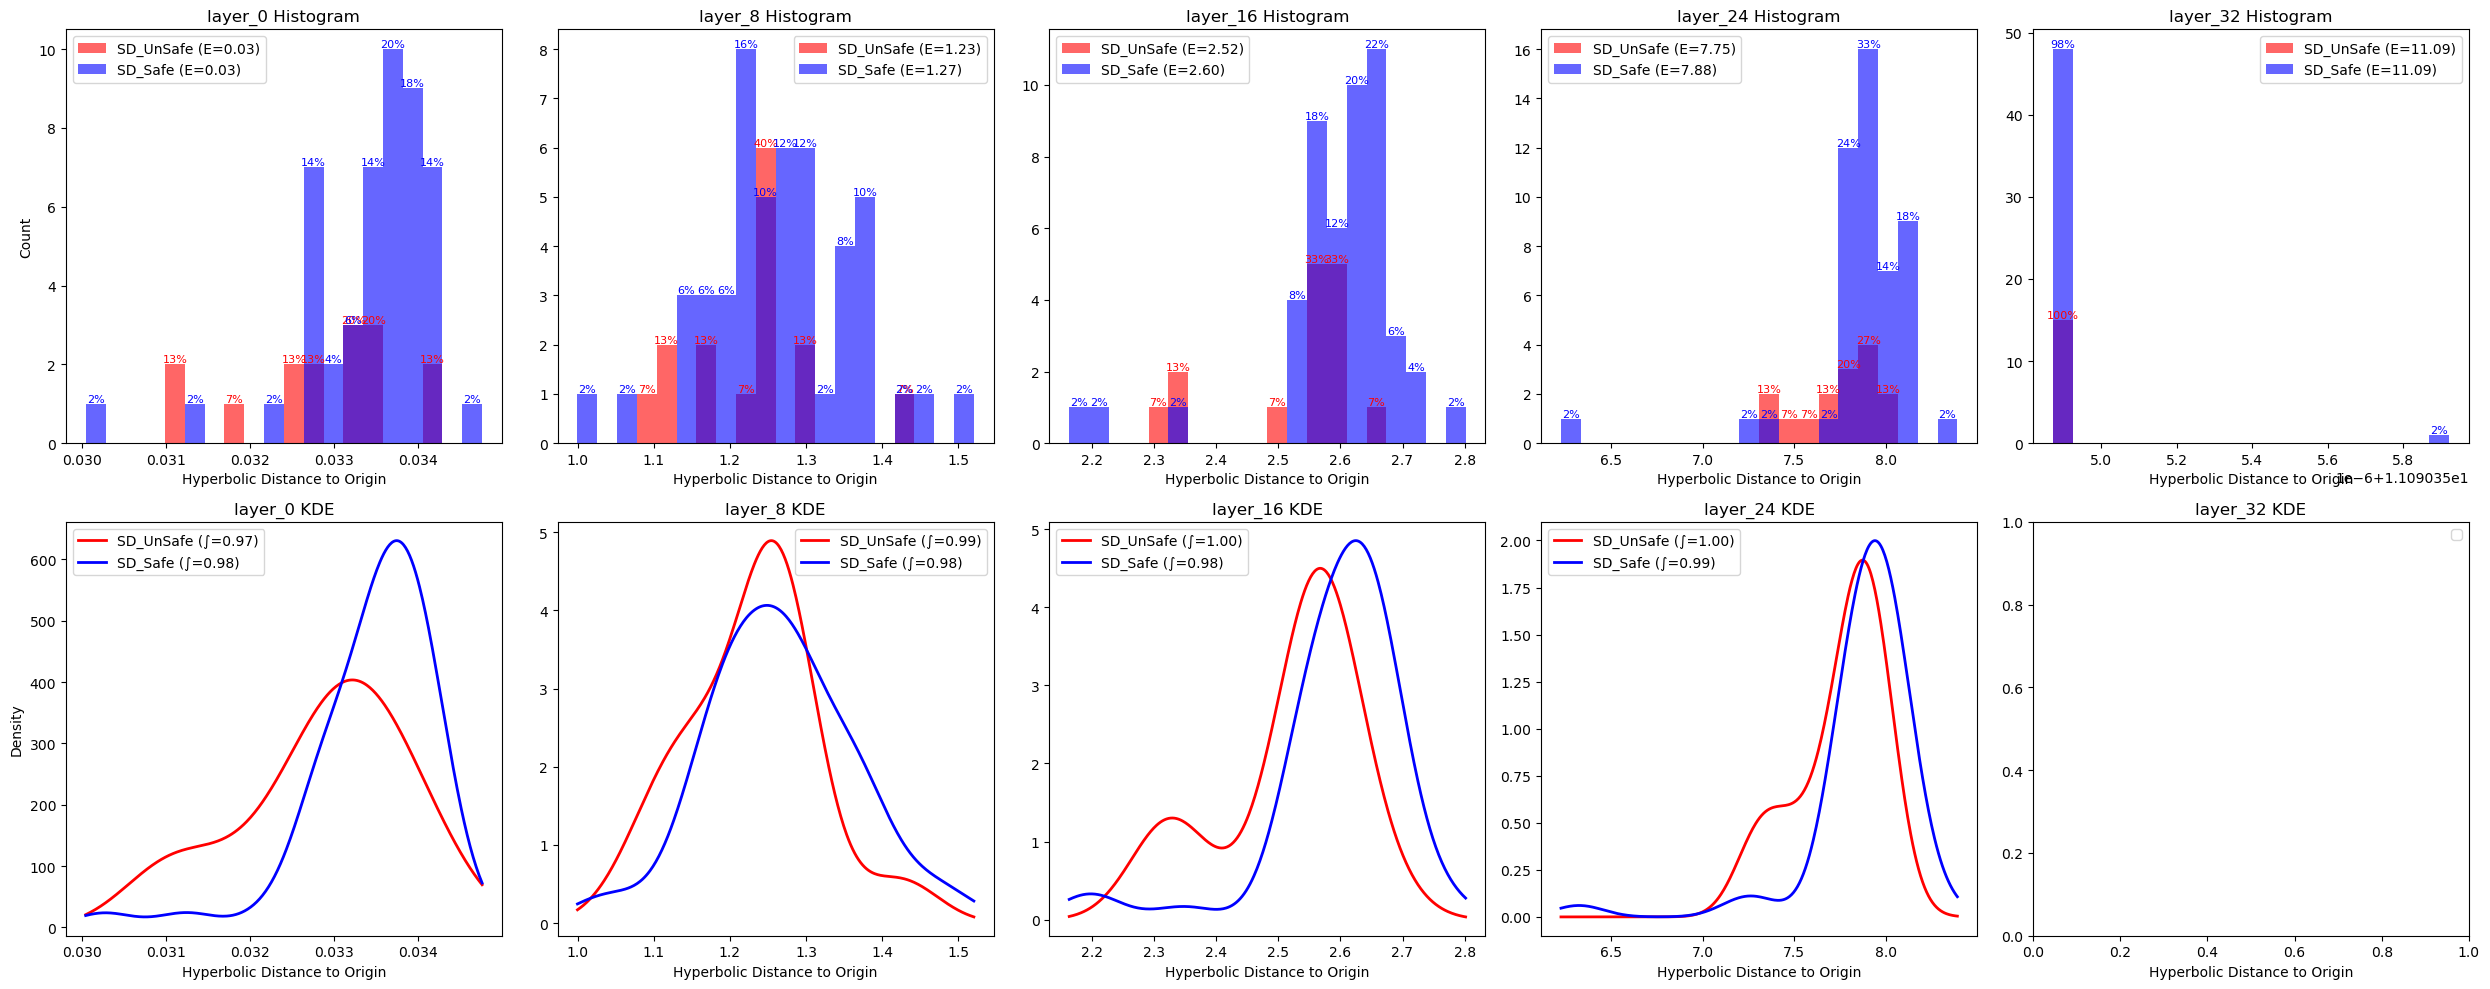

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from numpy import trapz  # 用于数值积分

layers = {
    "layer_0": dist_0,
    "layer_8": dist_8,
    "layer_16": dist_16,
    "layer_24": dist_24,
    "layer_32": dist_32,
}

num_layers = len(layers)

# 每层两个子图 → 总共 2*num_layers
fig, axes = plt.subplots(2, num_layers, figsize=(25, 10))
# axes[0] = 直方图行，axes[1] = KDE 曲线行
axes_hist = axes[0]
axes_kde  = axes[1]

attack_mask = mt_attack_labels.to(torch.bool)  # True=Unsafe, False=Safe

for i, (layer_name, dist) in enumerate(layers.items()):
    # 数据准备
    dist = dist.to(torch.float).cpu().numpy()
    dist_unsafe = dist[attack_mask.cpu().numpy()]
    dist_safe   = dist[~attack_mask.cpu().numpy()]

    # 期望值
    mean_unsafe = dist_unsafe.mean() if len(dist_unsafe) > 0 else float("nan")
    mean_safe   = dist_safe.mean() if len(dist_safe) > 0 else float("nan")

    # 范围
    d_min = min(dist_safe.min(), dist_unsafe.min())
    d_max = max(dist_safe.max(), dist_unsafe.max())
    if d_min == d_max:
        d_min -= 1e-6
        d_max += 1e-6
    margin = 0.05 * (d_max - d_min)
    bin_edges = np.linspace(d_min - margin, d_max + margin, 21)
    bin_width = bin_edges[1] - bin_edges[0]

    # ====== 直方图子图 ======
    ax_hist = axes_hist[i]
    counts_unsafe, _, patches_unsafe = ax_hist.hist(
        dist_unsafe, bins=bin_edges, color="red", alpha=0.6,
        label=f"SD_UnSafe (E={mean_unsafe:.2f})"
    )
    counts_safe, _, patches_safe = ax_hist.hist(
        dist_safe, bins=bin_edges, color="blue", alpha=0.6,
        label=f"SD_Safe (E={mean_safe:.2f})"
    )

    # 转换为百分比并显示
    perc_unsafe = counts_unsafe / (counts_unsafe.sum() + 1e-8) * 100
    perc_safe   = counts_safe / (counts_safe.sum() + 1e-8) * 100
    for count, patch, perc in zip(counts_unsafe, patches_unsafe, perc_unsafe):
        if count > 0:
            ax_hist.text(patch.get_x() + patch.get_width()/2, count,
                         f"{perc:.0f}%", ha="center", va="bottom",
                         fontsize=8, color="red")
    for count, patch, perc in zip(counts_safe, patches_safe, perc_safe):
        if count > 0:
            ax_hist.text(patch.get_x() + patch.get_width()/2, count,
                         f"{perc:.0f}%", ha="center", va="bottom",
                         fontsize=8, color="blue")

    ax_hist.set_title(f"{layer_name} Histogram")
    ax_hist.set_xlabel("Hyperbolic Distance to Origin")
    if i == 0:
        ax_hist.set_ylabel("Count")
    ax_hist.legend()

    # ====== KDE 曲线子图 ======
    ax_kde = axes_kde[i]
    x_vals = np.linspace(d_min - margin, d_max + margin, 400)

    if len(dist_unsafe) > 1 and np.var(dist_unsafe) > 1e-8:
        kde_unsafe = gaussian_kde(dist_unsafe)
        y_unsafe = kde_unsafe(x_vals)
        integral_unsafe = trapz(y_unsafe, x_vals)
        ax_kde.plot(x_vals, y_unsafe, color="red", lw=2,
                    label=f"SD_UnSafe (∫={integral_unsafe:.2f})")

    if len(dist_safe) > 1 and np.var(dist_safe) > 1e-8:
        kde_safe = gaussian_kde(dist_safe)
        y_safe = kde_safe(x_vals)
        integral_safe = trapz(y_safe, x_vals)
        ax_kde.plot(x_vals, y_safe, color="blue", lw=2,
                    label=f"SD_Safe (∫={integral_safe:.2f})")

    ax_kde.set_title(f"{layer_name} KDE")
    ax_kde.set_xlabel("Hyperbolic Distance to Origin")
    if i == 0:
        ax_kde.set_ylabel("Density")
    ax_kde.legend()

plt.tight_layout()
plt.show()


#### $R^{4096}$上的欧几里得距离分布，欧几里得原点为各隐藏层所有张量的均值并进行了L2归一化

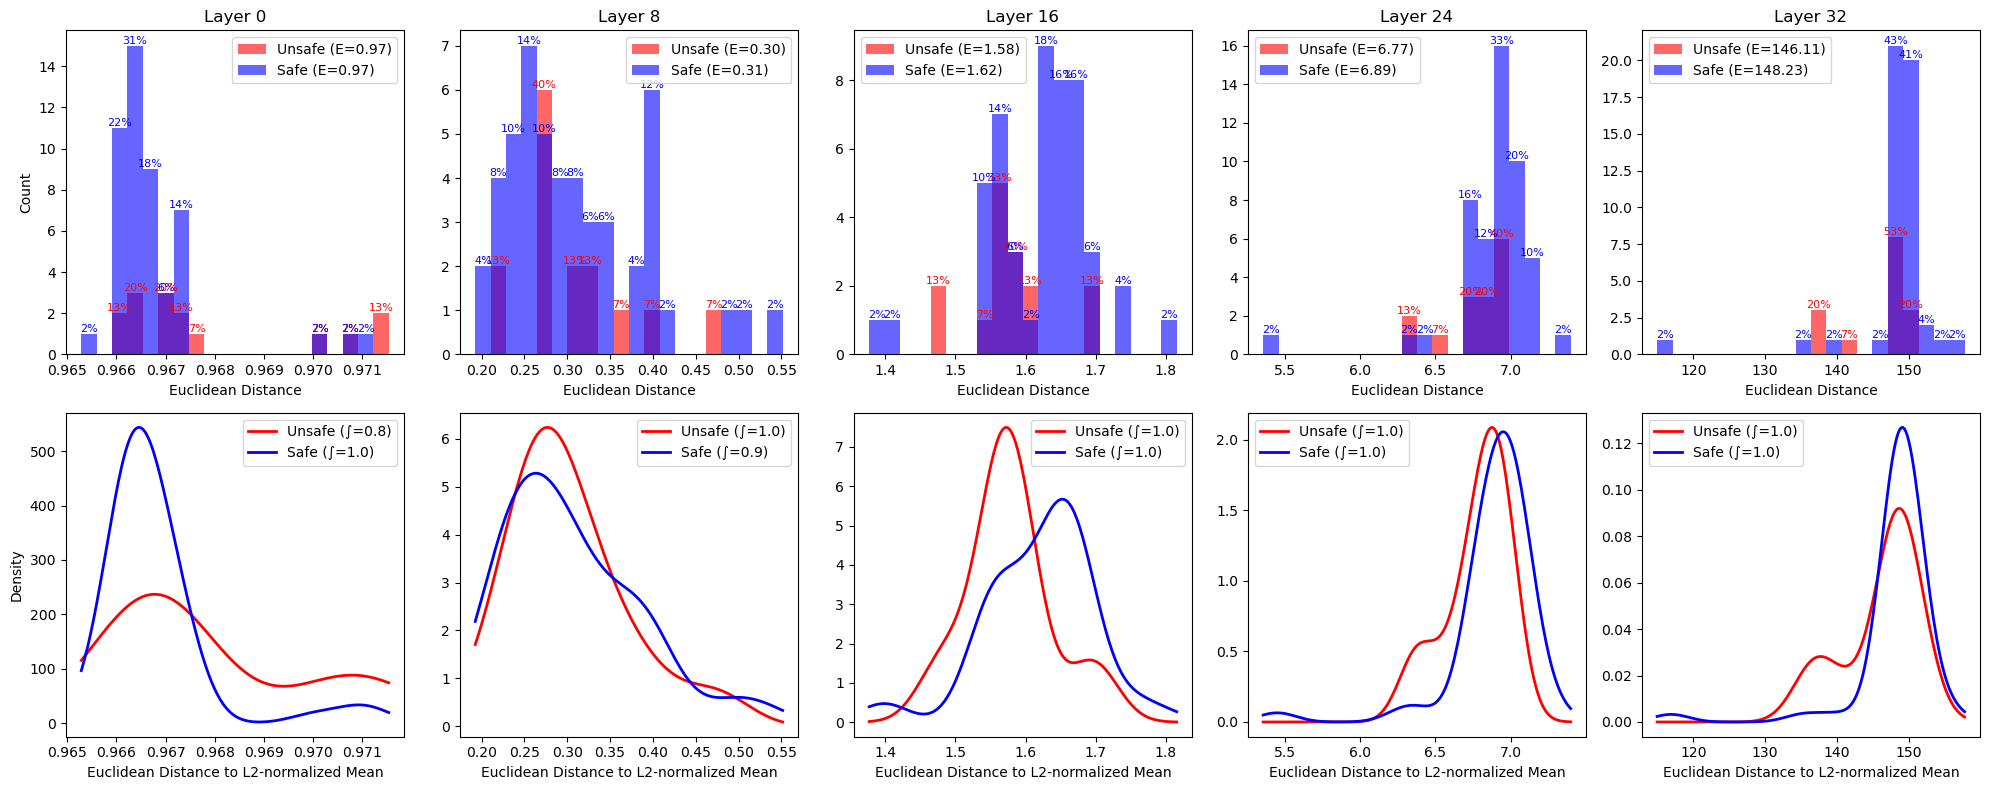

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from numpy import trapz  # 用于计算积分

layers = {
    "Layer 0": layer_0_features,
    "Layer 8": layer_8_features,
    "Layer 16": layer_16_features,
    "Layer 24": layer_24_features,
    "Layer 32": layer_32_features,
}

num_layers = len(layers)
fig, axes = plt.subplots(2, num_layers, figsize=(20, 8), sharey=False)  # 两行：直方图 + KDE
axes = axes.reshape(2, num_layers)

attack_mask = mt_attack_labels.to(torch.bool)  # True=Unsafe, False=Safe

for i, (layer_name, layer_tensor) in enumerate(layers.items()):
    # ========== Step 1: 计算欧几里得距离 ==========
    mu = layer_tensor.mean(dim=0, keepdim=True)
    mu_norm = mu / mu.norm(p=2, dim=1, keepdim=True)
    dists = torch.norm(layer_tensor - mu_norm, p=2, dim=1)

    dists_unsafe = dists[attack_mask].cpu().numpy()
    dists_safe   = dists[~attack_mask].cpu().numpy()

    mean_unsafe = dists_unsafe.mean() if len(dists_unsafe) > 0 else float("nan")
    mean_safe   = dists_safe.mean() if len(dists_safe) > 0 else float("nan")

    # 范围 & bins
    d_min = min(dists_safe.min(), dists_unsafe.min())
    d_max = max(dists_safe.max(), dists_unsafe.max())
    if d_min == d_max:  # 特殊情况
        d_min -= 1e-6
        d_max += 1e-6
    margin = 0.05 * (d_max - d_min)
    bin_edges = np.linspace(d_min - margin, d_max + margin, 21)

    # ========== Step 2a: 绘制直方图 ==========
    ax_hist = axes[0, i]
    counts_unsafe, _, patches_unsafe = ax_hist.hist(
        dists_unsafe, bins=bin_edges, color="red", alpha=0.6,
        label=f"Unsafe (E={mean_unsafe:.2f})"
    )
    counts_safe, _, patches_safe = ax_hist.hist(
        dists_safe, bins=bin_edges, color="blue", alpha=0.6,
        label=f"Safe (E={mean_safe:.2f})"
    )

    # 百分比标注
    perc_unsafe = counts_unsafe / (counts_unsafe.sum() + 1e-8) * 100
    perc_safe   = counts_safe / (counts_safe.sum() + 1e-8) * 100
    for count, patch, perc in zip(counts_unsafe, patches_unsafe, perc_unsafe):
        if count > 0:
            ax_hist.text(patch.get_x() + patch.get_width()/2, count,
                         f"{perc:.0f}%", ha="center", va="bottom",
                         fontsize=8, color="red")
    for count, patch, perc in zip(counts_safe, patches_safe, perc_safe):
        if count > 0:
            ax_hist.text(patch.get_x() + patch.get_width()/2, count,
                         f"{perc:.0f}%", ha="center", va="bottom",
                         fontsize=8, color="blue")

    ax_hist.set_title(layer_name)
    ax_hist.set_xlabel("Euclidean Distance")
    if i == 0:
        ax_hist.set_ylabel("Count")
    ax_hist.legend()

    # ========== Step 2b: 绘制 KDE 曲线 ==========
    ax_kde = axes[1, i]
    x_vals = np.linspace(d_min - margin, d_max + margin, 200)

    # bin 宽度用于缩放
    bin_width = bin_edges[1] - bin_edges[0]

    if len(dists_unsafe) > 1 and np.var(dists_unsafe) > 1e-8:
        kde_unsafe = gaussian_kde(dists_unsafe)
        y_unsafe = kde_unsafe(x_vals)
        area_unsafe = trapz(y_unsafe, x_vals)  # 积分值
        ax_kde.plot(x_vals, y_unsafe, color="red", lw=2,
                    label=f"Unsafe (∫={area_unsafe:.1f})")

    if len(dists_safe) > 1 and np.var(dists_safe) > 1e-8:
        kde_safe = gaussian_kde(dists_safe)
        y_safe = kde_safe(x_vals)
        area_safe = trapz(y_safe, x_vals)
        ax_kde.plot(x_vals, y_safe, color="blue", lw=2,
                    label=f"Safe (∫={area_safe:.1f})")

    ax_kde.set_xlabel("Euclidean Distance to L2-normalized Mean")
    if i == 0:
        ax_kde.set_ylabel("Density")
    ax_kde.legend()

plt.tight_layout()
plt.show()